# Riproduzione del modello di Fiaschi

$k = W_1^T * x$

$z = R(k)$

$\hat{y} = W_2^T * z$

- Dopo aver addestrato per la Loss principale, si aggiunge un nuovo layer di proiezione in mezzo alle ultime due equazioni, tale che:

$\hat{y} = W_2^T * P_{z^{(y=1)}}(z)$

In [184]:
import torch
import torch.nn as nn
from dataset import Dataset
import matplotlib.pyplot as plt
import numpy as np

import sys

In [185]:
class ModelloFiaschi(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(ModelloFiaschi, self).__init__()
        
        self.ort_base = torch.eye(hidden_size)
        self.loss = nn.BCEWithLogitsLoss()

        self.W1 = nn.Linear(input_size, hidden_size)
        self.W2 = nn.Linear(hidden_size, output_size)

        self.ReLU = nn.ReLU()
        self.Sigmoid = nn.Sigmoid()

        self.optimizer = torch.optim.Adam(self.parameters())


    def without_projection(self, x):
        k = self.W1(x)
        z = self.ReLU(k)
        y = self.W2(z)
        
        return y, z.clone().detach()


    def with_projection(self, x):
        k = self.W1(x)
        z = self.ReLU(k)
        z_p = self._Projection(z)
        y = self.W2(z_p)
        
        return y, z_p.clone().detach()

    
    def generate_orthogonal_base(self, dl):
        base = None
        with torch.no_grad():
            for x, _ in dl:  
                _, v = self.without_projection(x)
                if base is None:
                    base = v
                else:
                    base = torch.cat((base, v), dim = 0)

        q, r = torch.linalg.qr(base.T, mode = 'reduced')
        diag = torch.diagonal(r)
        mask = torch.where(diag != 0)
        base = q.T[mask]

        self.ort_base = self._orthogonal_base(base)

    def _orthogonal_base(self, A):
            A = A.T

            AAT = torch.matmul(A.T, A)
            AAT_INV = torch.linalg.solve(AAT, torch.eye(AAT.shape[0])) 

            P_a = torch.matmul(A, AAT_INV) 
            P_a = torch.matmul(P_a, A.T)
            
            P = torch.eye(P_a.shape[0]) - P_a
            return P


    def _Projection(self, u):
        return torch.matmul(u, self.ort_base)

# ===================================================================

    def forward(self, x):
        with torch.no_grad():
            y, _ = self.with_projection(x)
        return y

    def error_L1(self, dl):
        error = np.array([])
        with torch.no_grad():
            for x,y in dl:
                y_pred, _ = self.with_projection(x)
                e = self.loss(y_pred, y.unsqueeze(1))

                error = np.concatenate((error, [e.detach().numpy()]))

        return error.mean()
        

    def train_on_L1(self, dl):
        error = np.array([])
        for x,y in dl:
            self.optimizer.zero_grad()

            y_pred, _ = self.without_projection(x)
            
            e = self.loss(y_pred, y.unsqueeze(1))
            e.backward()
                
            self.optimizer.step()

            error = np.concatenate((error, [e.detach().numpy()]))

        return error.mean()

    
    def train_on_L2(self, dl):
        error = np.array([])
        for x,y in dl:
            self.optimizer.zero_grad()

            y_pred, _ = self.with_projection(x)
            
            e = self.loss(y_pred, y.unsqueeze(1))
            e.backward()
                
            self.optimizer.step()
            
            error = np.concatenate((error, [e.detach().numpy()]))

        return error.mean()


In [186]:
def print_space(modello, dataset,e11=[], e12=[], e22=[]):
    labels = dataset.labels
    dataset = dataset.dataset

    fig, plot = plt.subplots(1, 2, figsize=(20, 10))
    with torch.no_grad():
        points = [[x/4, y/4, modello(torch.tensor([x/4*1.0,y/4*1.0]))] for x in range(-4*4,8*4) for y in range(-3*4,13*4)]
    
    colori = ['red' if p[2][0] > 0.2 else 'blue' if p[2][0] < -0.2 else 'white' for p in points]

    plot[0].scatter([p[0] for p in points], [p[1] for p in points], c = colori, s=8)
    plot[0].scatter([p[0] for p in dataset],[p[1] for p in dataset], c=['red' if i == 1 else 'blue' for i in labels])
    plot[1].plot([x for x in range(len(e11))], e11,label='L1 on L1')
    plot[1].plot([x for x in range(len(e12))], e12, label='L1 on L2',color = 'red')
    plot[1].plot([x for x in range(len(e22))], e22, label='L2 on L2',color = 'blue')
    plt.legend()
    plt.show()

def print_space_2(modello, dataset,e11=[], e12=[], e22=[]):
    labels = dataset.labels
    dataset = dataset.dataset

    fig, plot = plt.subplots(1, 2, figsize=(20, 10))
    with torch.no_grad():
        points = [[x/4, y/4, modello(torch.tensor([x/4*1.0,y/4*1.0]))] for x in range(-4*4,8*4) for y in range(-3*4,13*4)]
    
    colori = ['red' if p[2][0] < 0.2 and p[2][0] > -0.2 else 'blue' for p in points]

    plot[0].scatter([p[0] for p in points], [p[1] for p in points], c = colori, s=8)
    plot[0].scatter([p[0] for p in dataset],[p[1] for p in dataset], c=['red' if i == 1 else 'blue' for i in labels])
    plot[1].plot([x for x in range(len(e11))], e11,label='L1 on L1')
    plot[1].plot([x for x in range(len(e12))], e12, label='L1 on L2',color = 'red')
    plot[1].plot([x for x in range(len(e22))], e22, label='L2 on L2',color = 'blue')
    plt.legend()
    plt.show()

In [187]:
torch.manual_seed(13)
modello = ModelloFiaschi(2,1,40)
ds = Dataset(8)
dl = ds.get_dataloader()
dl1, dl0 = ds.get_separated_dataloaders()

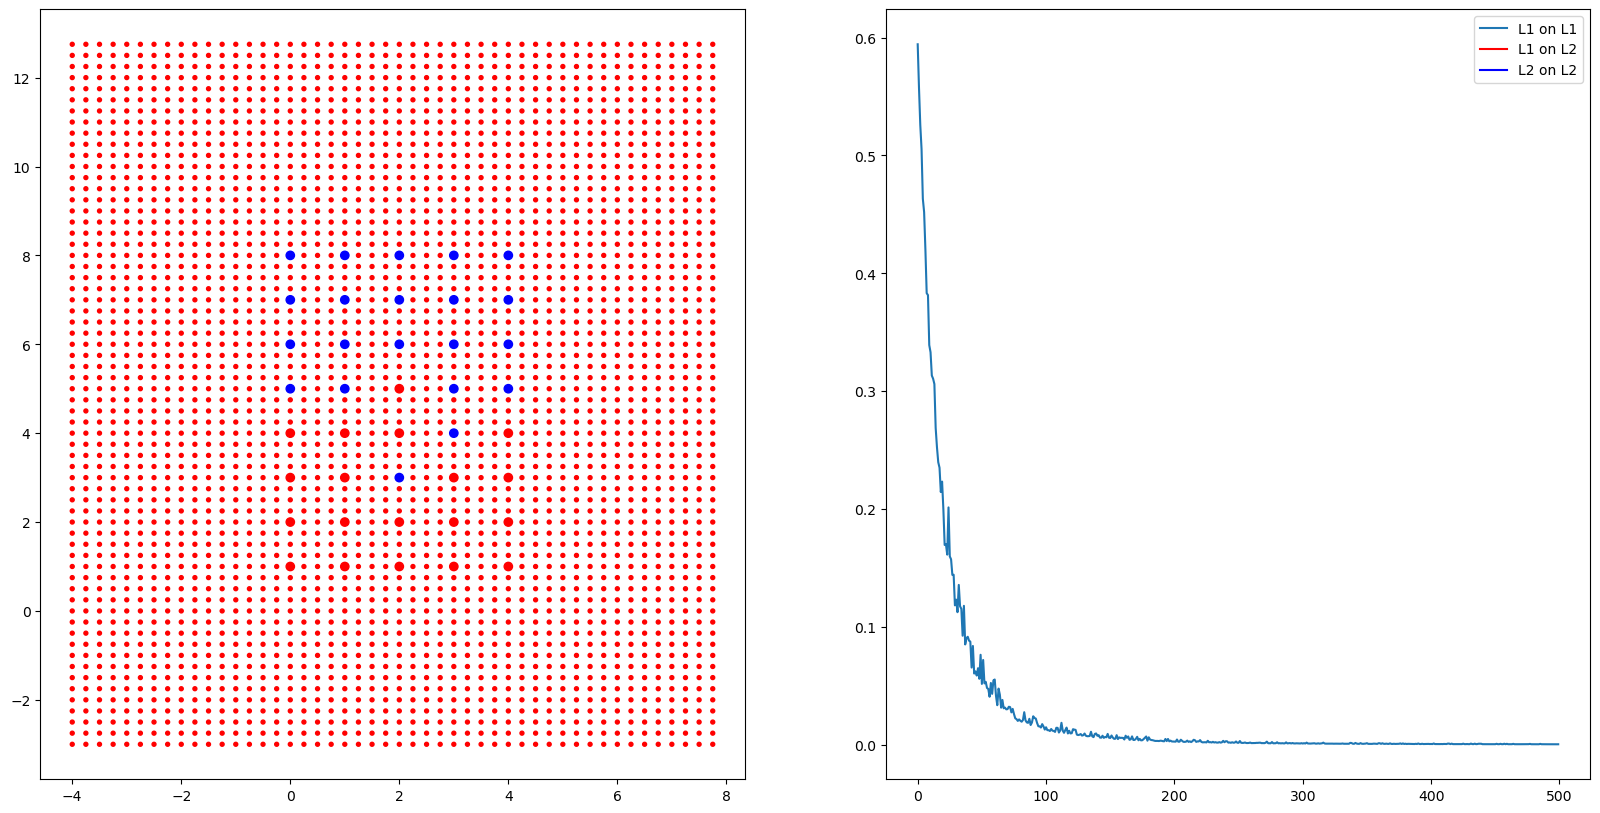

In [188]:
err_L1_L1 = []
for _ in range(500):
    err_L1_L1.append(modello.train_on_L1(dl1))

print_space(modello, ds, err_L1_L1)

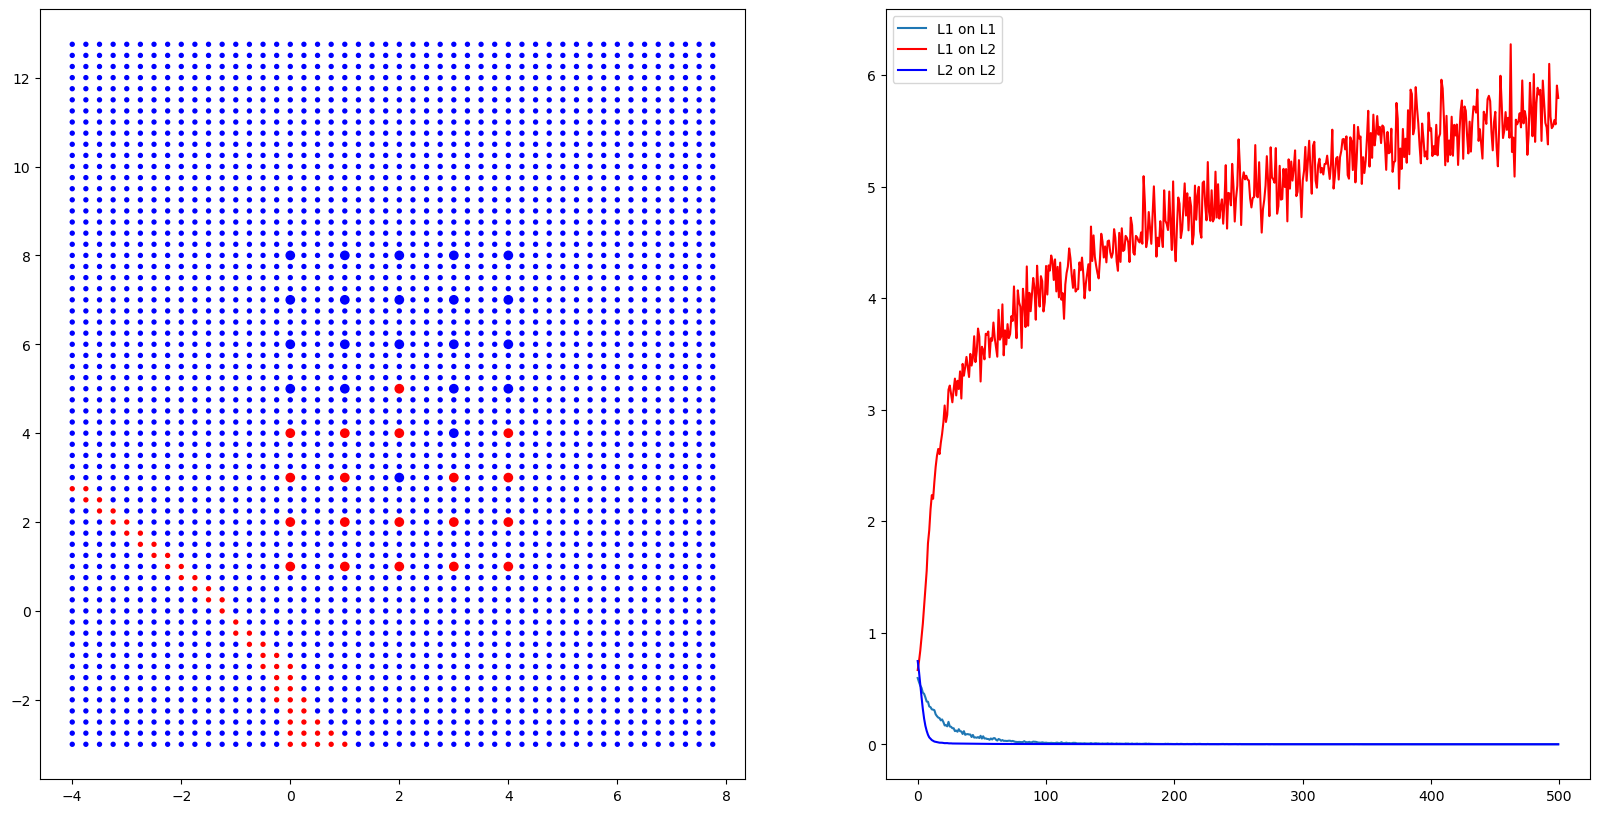

In [189]:
err_L1_L2 = []
err_L2_L2 = []
modello.generate_orthogonal_base(dl1)


for _ in range(500):
    err_L2_L2.append(modello.train_on_L2(dl0))
    err_L1_L2.append(modello.error_L1(dl1))

print_space_2(modello, ds, err_L1_L1, err_L1_L2, err_L2_L2)